PROJECT -  Fake Job Posting Detection

first have to indentify the type of data set is it
1. structured data
2. unstructured data

its a structured data set and we are going to use classifier model for the evaluations

Here the first step is to importing all the libraries

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE
import numpy as np
import joblib
import sklearn.model_selection as train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import zipfile
from sklearn.impute import SimpleImputer

Importing the Database as csv using pandas

In [2]:
# to import a csv file
# df = pd.read_csv('file_name')

# I am using zip extraction method to extract data
zip_path = r"C:\Users\Harsh Sharma\Downloads\fake_job_postings.zip"

# Open the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # List all files inside the ZIP
    print("fake_job_postings:")
    print(zip_ref.namelist())  # <-- Look at this output to find the exact CSV name

    # Use the exact CSV filename from the list
    csv_file_name = 'fake_job_postings.csv'  # <-- Replace with the actual CSV name inside ZIP

    # Read CSV from ZIP without extracting
    with zip_ref.open(csv_file_name) as f:
        df = pd.read_csv(f)
        print(df.head(3))

fake_job_postings:
['fake_job_postings.csv']
   job_id                                      title          location  \
0       1                           Marketing Intern  US, NY, New York   
1       2  Customer Service - Cloud Video Production    NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)     US, IA, Wever   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   

                                        requirements  \
0  Experience with content management systems a m...   


In [3]:
# review of correct data set
df.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


Creating a PIPELINE using sklearn module

In [4]:
# from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier #importing machine learning model through sklearn
# creating a pipeline to execute the prediction
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from sentence_transformers import SentenceTransformer

# classification of features

text_features = ['description', 'company_profile']
categorical_features = ['salary_range', 'location']
binary_features = ['has_company_logo']


preprocessor = ColumnTransformer([
    ('desc_vect', TfidfVectorizer(max_features=100), 'description'),
    ('prof_vect', TfidfVectorizer(max_features=100), 'company_profile'),
    ('sala_vect' , TfidfVectorizer(max_features=100) , 'salary_range'),
   ('loc_vect', TfidfVectorizer(max_features=50), 'location'),
    ('logo_enc', OrdinalEncoder(), ['has_company_logo'])
    ])# Important numeric feature

# 4. Final pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    # ('classifier', RandomForestClassifier(class_weight='balanced',random_state=42)) ,#its a simple class balancing function
    # ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000,random_state=42))
    ('classifier', XGBClassifier(
    scale_pos_weight=17,          # 17014 real / 866 fake
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
    ))
])


Verify the Feature and labels in the data

In [5]:
# verification of features and labels
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [6]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# checking for null section in data
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

Removal of NULL section inn data
there are three ways:
1. removal of null columns
2. replacing null with NA
3. replacing null with mean,mode

In [8]:
# df['location'] = df['location'].apply(lambda x : x.split(', '))
# we use replacing null with mode
df['location'] = df['location'].fillna(df['location'].mode()[0])
df['description'] = df['description'].fillna(df['description'].mode()[0])
df['benefits'] = df['benefits'].fillna(df['benefits'].mode()[0])
df['requirements'] = df['requirements'].fillna(df['requirements'].mode()[0])
df['department'] = df['department'].fillna(df['department'].mode()[0])
df['company_profile'] = df['company_profile'].fillna(df['company_profile'].mode()[0])

df['salary_range'] = df['salary_range'].fillna(df['salary_range'].mode()[0])

checking for the process is successfully executed

In [9]:
df.isnull().sum()

job_id                    0
title                     0
location                  0
department                0
salary_range              0
company_profile           0
description               0
requirements              0
benefits                  0
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
industry               4903
function               6455
fraudulent                0
dtype: int64

In [10]:
df_loc = df['location'].apply(lambda x : x.split(', '))
df_loc.head(5)

0      [US, NY, New York]
1        [NZ, , Auckland]
2         [US, IA, Wever]
3    [US, DC, Washington]
4    [US, FL, Fort Worth]
Name: location, dtype: object

Ploting graphs for data visualisation

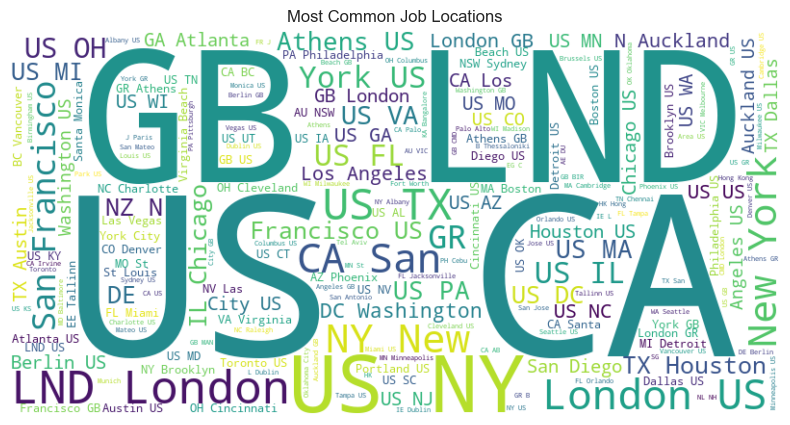

In [11]:
# its a worldcloud plot resemble how many  jobs from which countries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text in a column (e.g., location or description)
text = " ".join(df['location'].dropna())

# Generate word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(text)

# Display it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Job Locations')
plt.show()


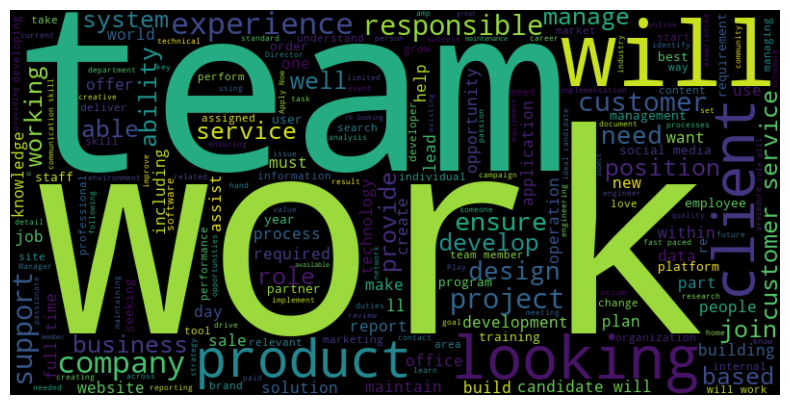

In [12]:
from wordcloud import WordCloud
text = ' '.join(df['description'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

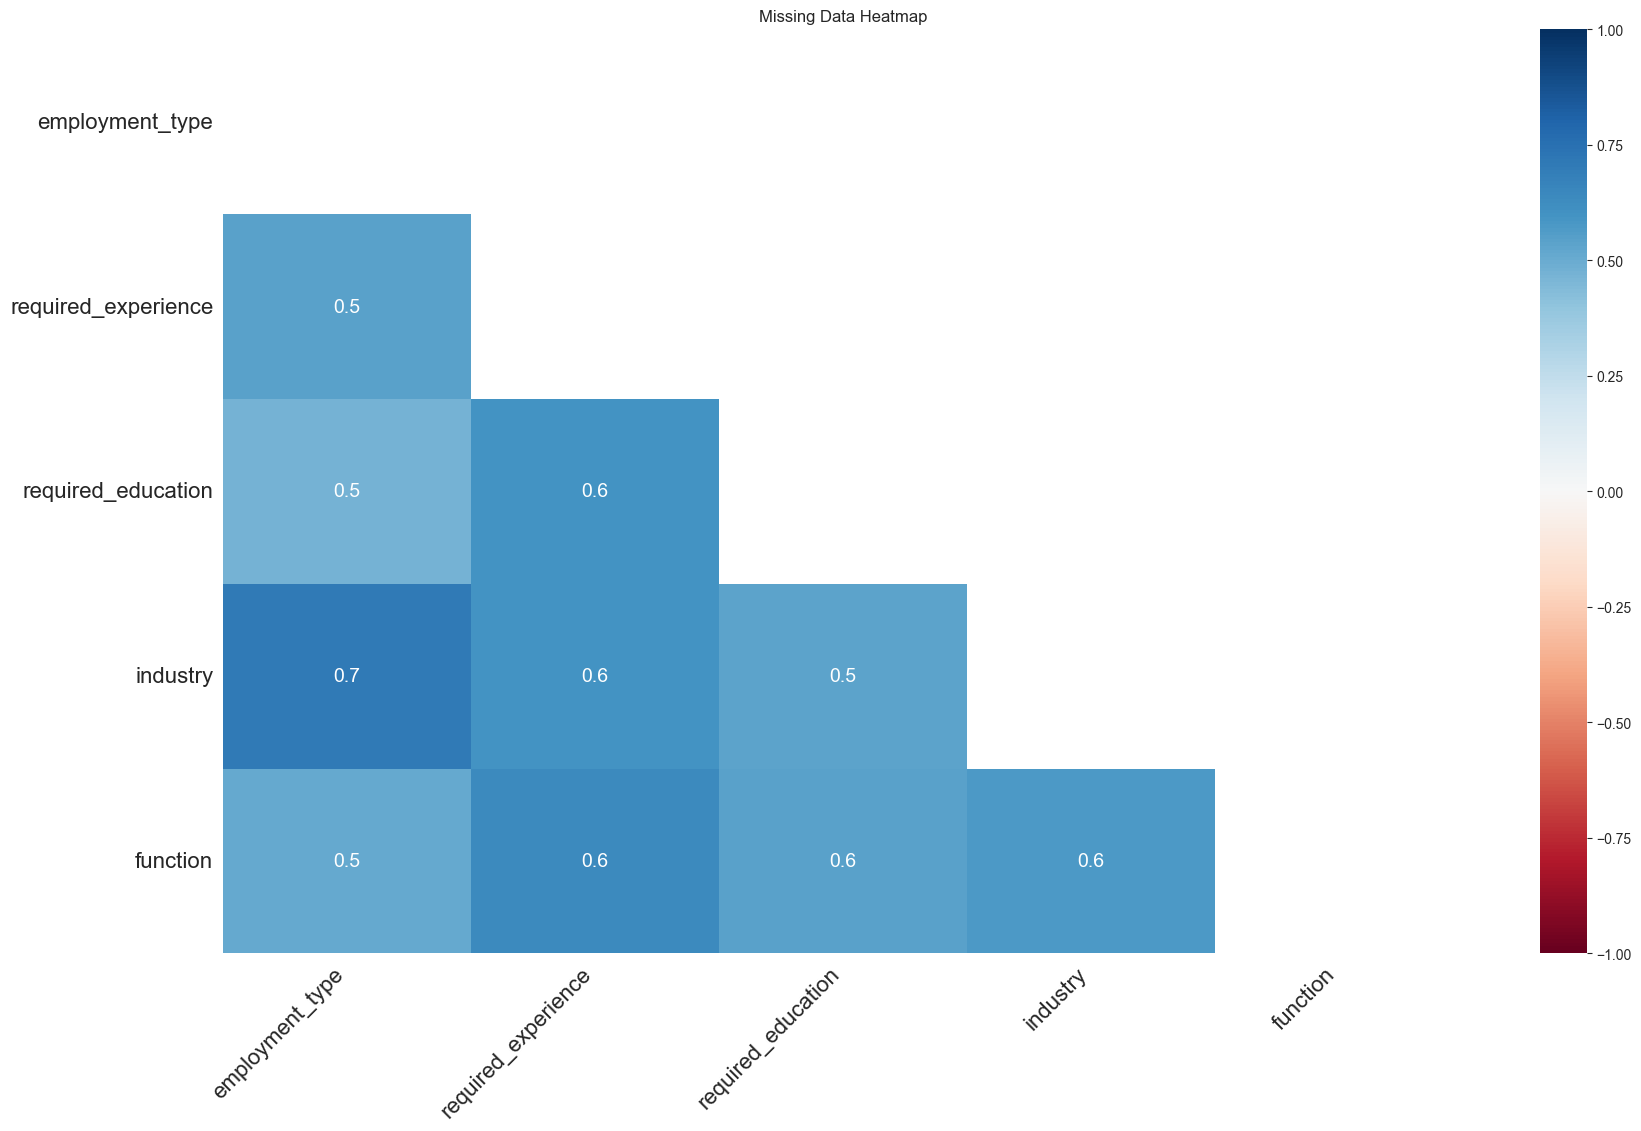

In [13]:
# heatmap of missing data
import missingno as msno

msno.heatmap(df)
plt.title("Missing Data Heatmap")
plt.show()

Here is spliting of data in ration 80:20 for training and testing

In [14]:
from sklearn.model_selection import train_test_split

X = df[[ 'description', 'company_profile' , 'salary_range' , 'has_company_logo' , 'location' ]]
y = df['fraudulent']  # Assuming this is your target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Class balancing using SMOTE usually for strong balancing

In [15]:
# from sklearn.compose import ColumnTransformer
# from sklearn.feature_extraction.text import TfidfVectorizer
# preprocessor = ColumnTransformer([
#     ('desc_vect', TfidfVectorizer(max_features=100), 'description'),
#     ('prof_vect', TfidfVectorizer(max_features=100), 'company_profile'),
#     ('sala_vect' , TfidfVectorizer(max_features=100) , 'salary_range')
# ])
# for string class balancing we use smote
# X_train_vec = preprocessor.fit_transform(X_train)
# X_test_vec = preprocessor.transform(X_test)
#
# # 4. Apply SMOTE to the vectorized training data
# sm = SMOTE(random_state=42)
# X_resampled, y_resampled = sm.fit_resample(X_train_vec, y_train)
#
# # 5. Train the classifier with class_weight
# clf = RandomForestClassifier(class_weight='balanced', random_state=42)
# clf.fit(X_resampled, y_resampled)


simple class balancing  in regression classifier function

In [16]:
# 5. Train the model
pipeline.fit(X_train, y_train)

# 6. Evaluate
from sklearn.metrics import classification_report, confusion_matrix
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\Harsh Sharma\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:48:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[[3355   40]
 [  43  138]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3395
           1       0.78      0.76      0.77       181

    accuracy                           0.98      3576
   macro avg       0.88      0.88      0.88      3576
weighted avg       0.98      0.98      0.98      3576



Plot of the output but the model


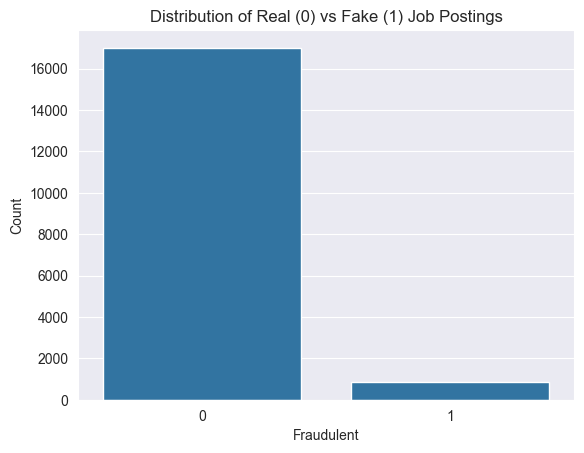

In [17]:
import seaborn as sns
sns.countplot(x='fraudulent', data=df)
plt.title('Distribution of Real (0) vs Fake (1) Job Postings')
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.show()

finally saving the model in the system by joblib

In [19]:
import cloudpickle as cp
with open("fake_job_model.pkl", "wb") as f:
    cp.dump(pipeline, f)

Check for if class is balanced or not

In [20]:
df['fraudulent'].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

Evaluation of model

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3395
           1       0.78      0.76      0.77       181

    accuracy                           0.98      3576
   macro avg       0.88      0.88      0.88      3576
weighted avg       0.98      0.98      0.98      3576



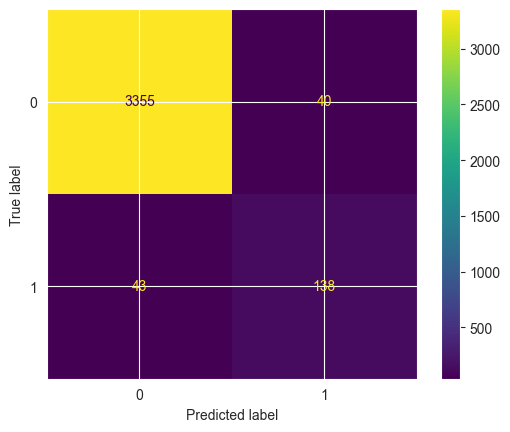

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred = pipeline.predict(X_test)

# Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [22]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

array([[3355,   40],
       [  43,  138]])

Testing of model with user input

In [23]:
# New test job (you can customize this!)
new_job = pd.DataFrame({
    'description': ["We are urgently hiring an international data analyst to work remotely and earn up to $7000/month."],
    'company_profile': ["A leading global business offering investment solutions worldwide."],
    'salary_range': ["$6000-$7000"],
    'has_company_logo': [1],
    'location': ['usa'],
})

# Predict
prediction = pipeline.predict(new_job)

In [24]:
print(" Prediction:", "Fake" if prediction[0] == 1  else "Real")

 Prediction: Real


In [25]:
# New test job (you can customize this!)
new_job = pd.DataFrame({
    'description': ["We are urgently hiring an international data analyst to work remotely and earn up to $7000/month."],
    'company_profile': ["A leading global business offering investment solutions worldwide."],
    'salary_range': ["$6000-$7000"],
    'has_company_logo': [0],
    'location': [''],
})

# Predict
prediction = pipeline.predict(new_job)

In [26]:
print(" Prediction:", "Fake" if prediction[0] == 1 else "Real")
# print(f"Confidence → Real: {proba[0][0]:.2f}, Fake: {proba[0][1]:.2f}")

 Prediction: Fake
